## 5%検定をしたときの3つの検定の比較

2つの二項分布をデータ生成モデルとした状況において，Pearsonの$\chi^2$検定，$\frac{n-1}{n}$補正の$\chi^2$検定，表の生起確率に基づくmid-p版Fisher「正確」検定で，名目的な有意水準を5%として検定したとき，実質的な有意水準がどれぐらいになるかを求めてみました．
各プロットは，各群の標本サイズ(n1, n2)において，X軸に二項分布の確率$\pi$を，Y軸に実質的な有意水準をプロットしたものです．

- ***TODO: バグがないか確認***
- TODO: ループを使わないようにプログラミング
- TODO: 特にmid-pの計算を工夫する
- TODO: プロットの凡例を外に出す
- TODO: グラフのレイアウトを綺麗に

***履歴***
- 2020/1/1 6:53 乱数から有意／非有意を判定するループをmap関数に変更

In [73]:
#バージョンの表示
versioninfo()

Julia Version 1.3.0
Commit 46ce4d7933 (2019-11-26 06:09 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i3-5005U CPU @ 2.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, broadwell)


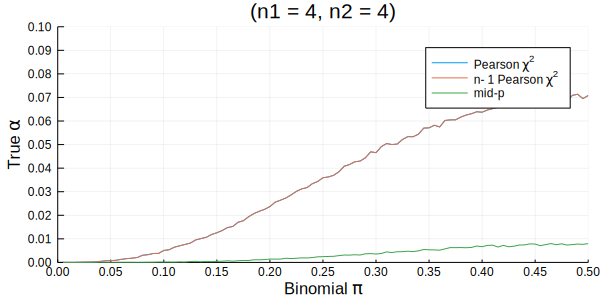

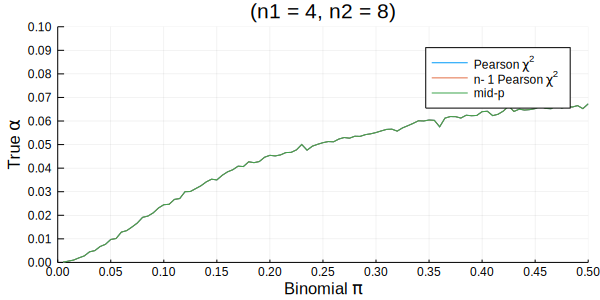

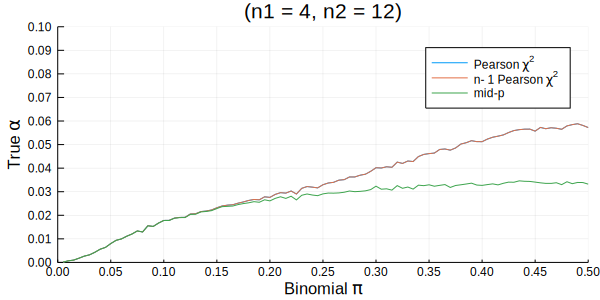

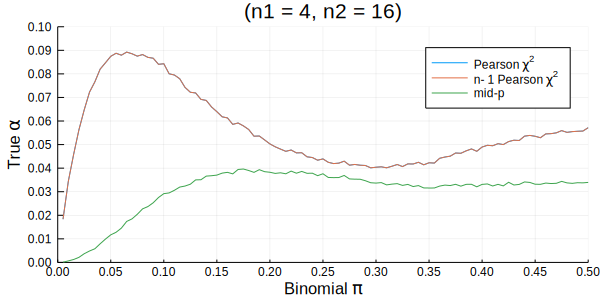

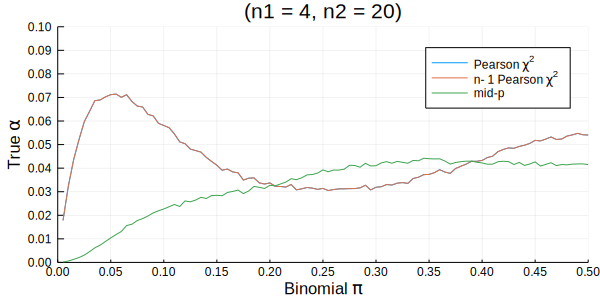

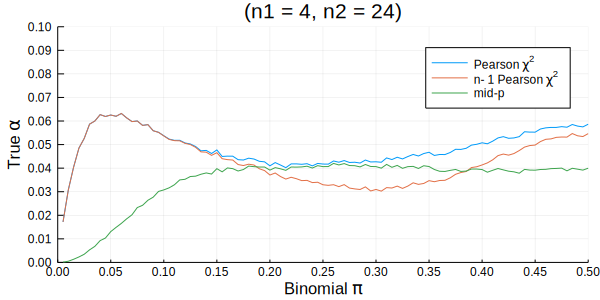

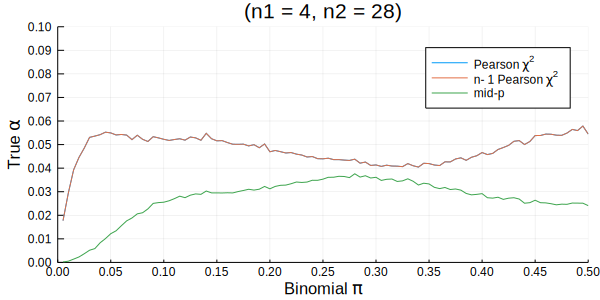

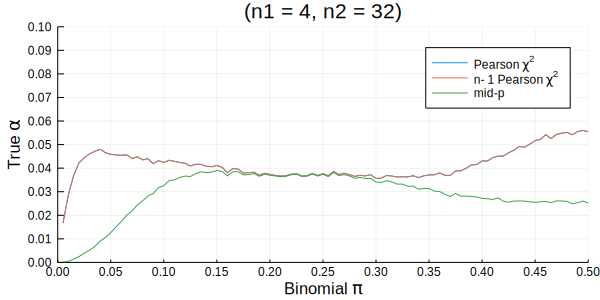

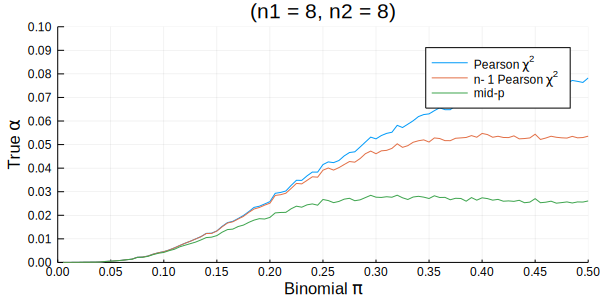

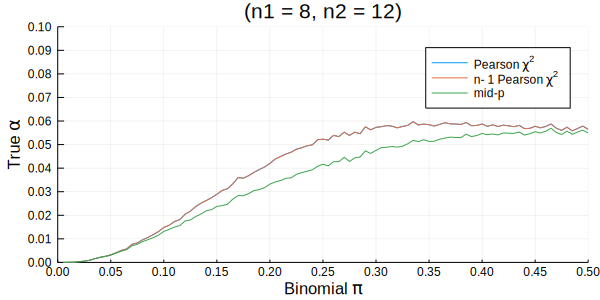

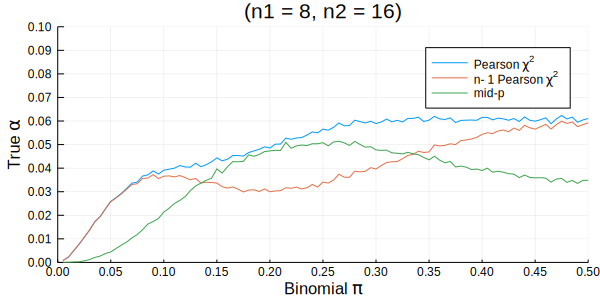

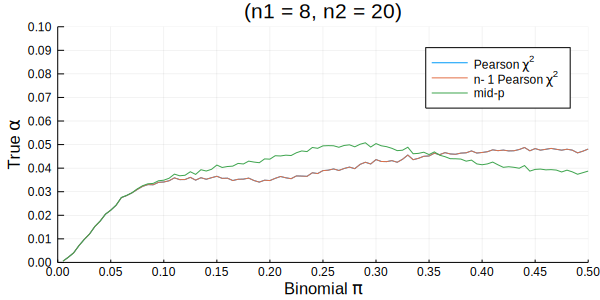

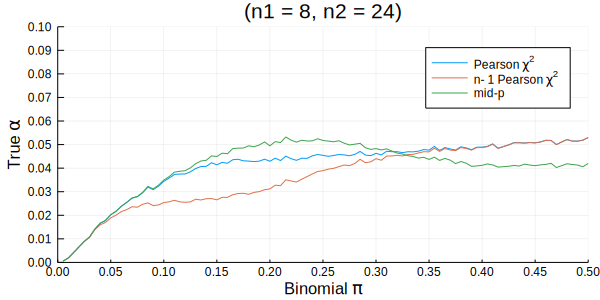

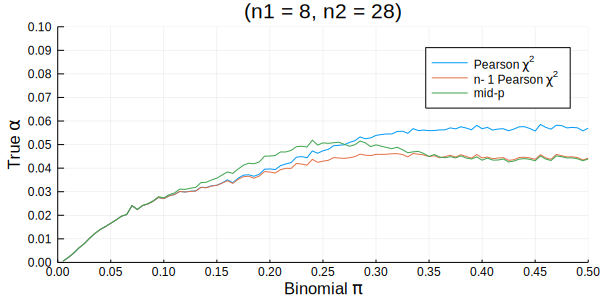

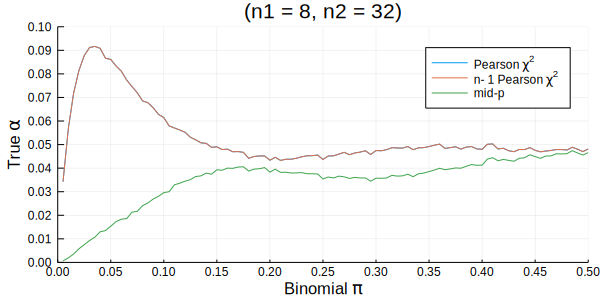

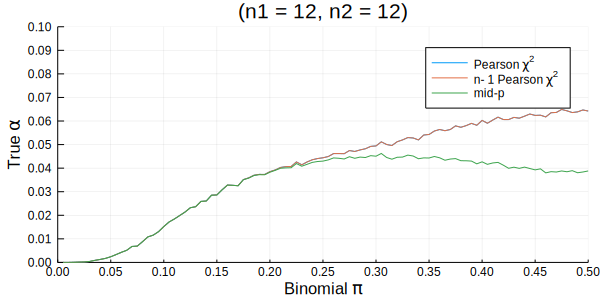

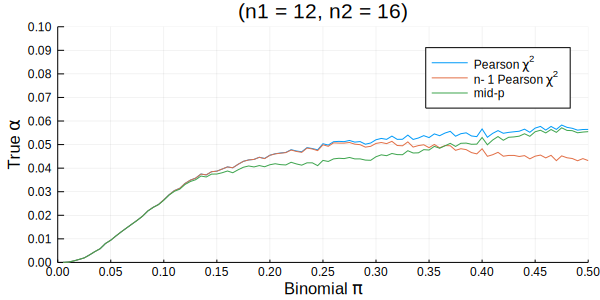

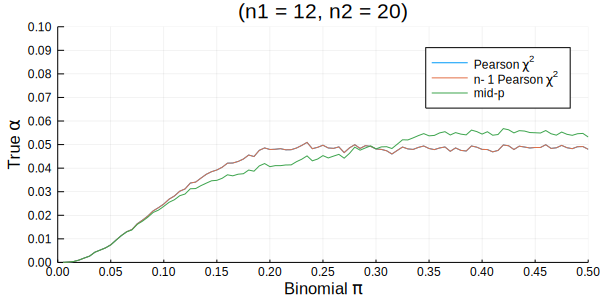

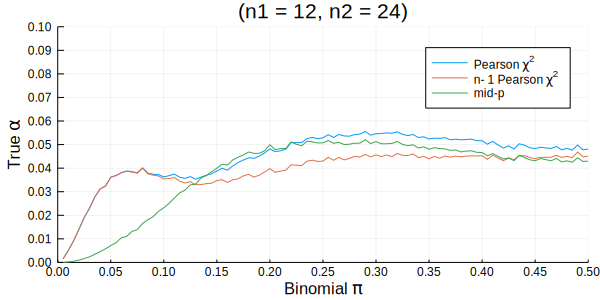

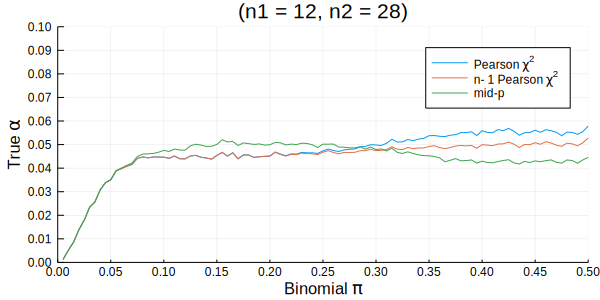

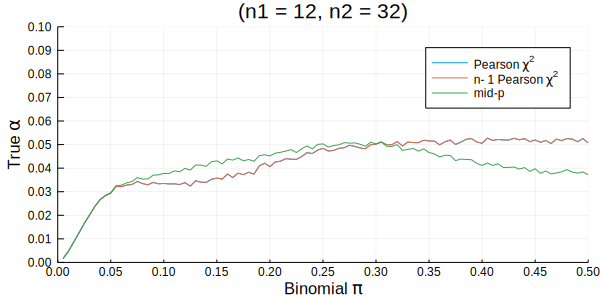

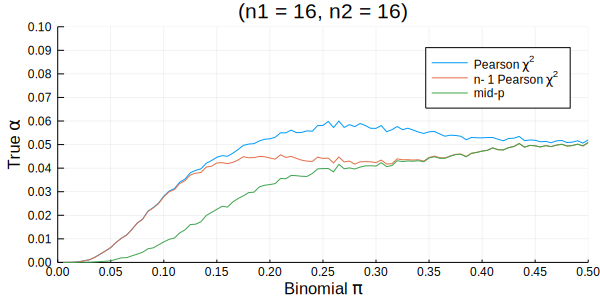

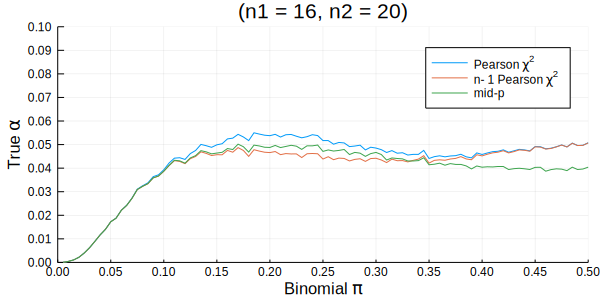

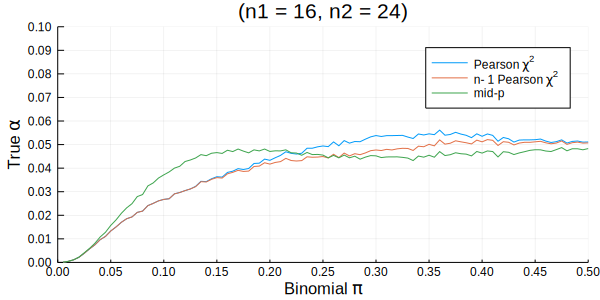

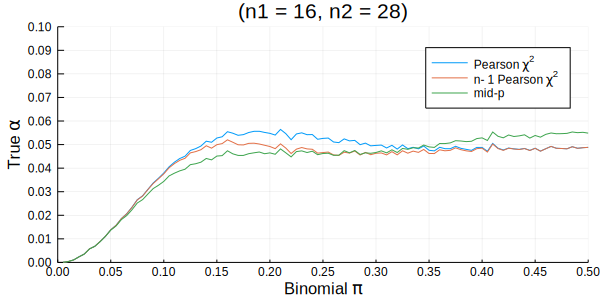

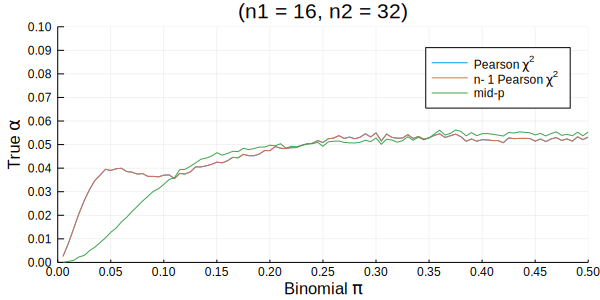

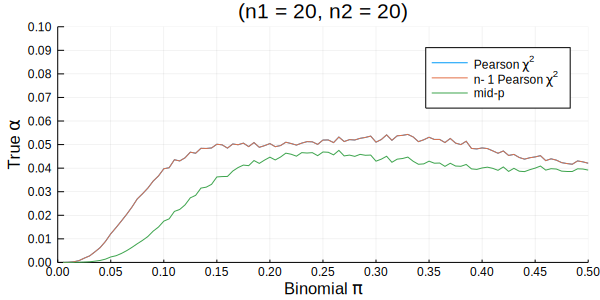

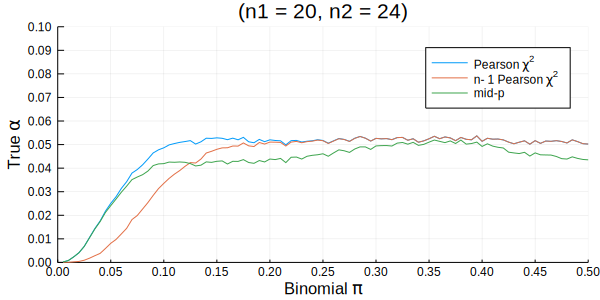

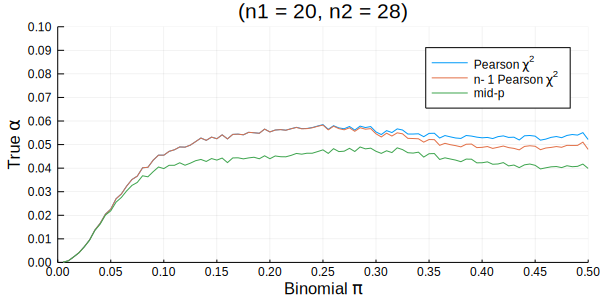

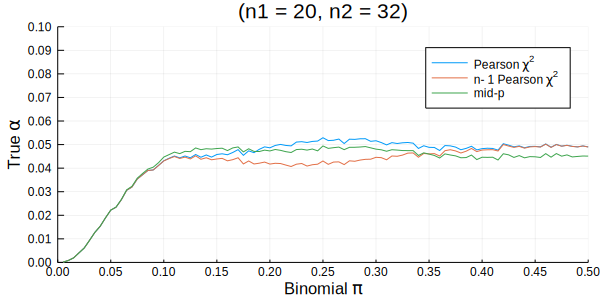

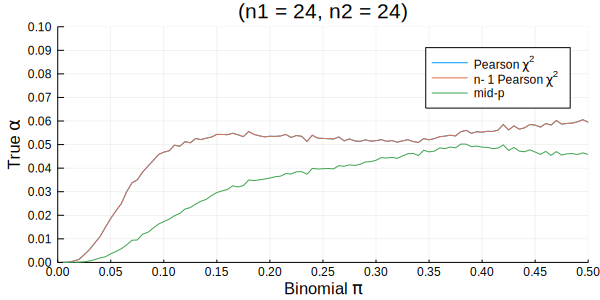

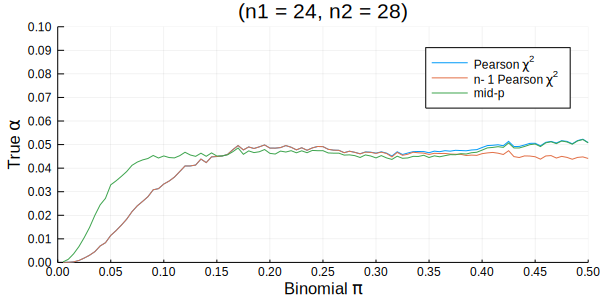

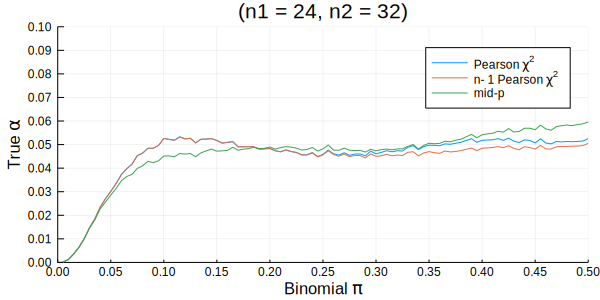

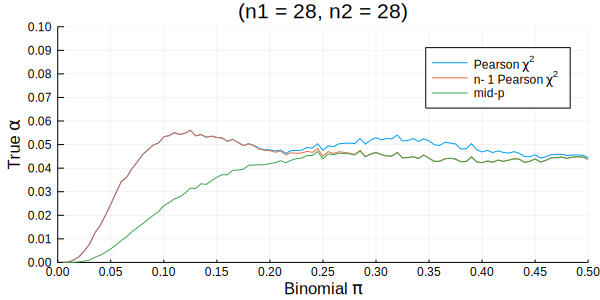

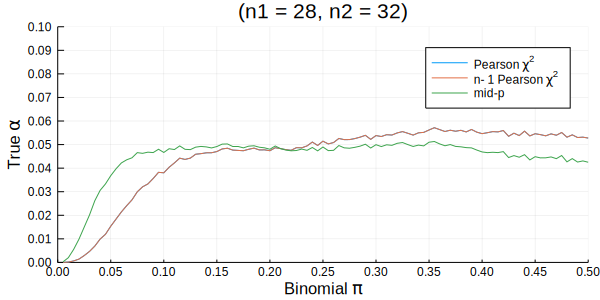

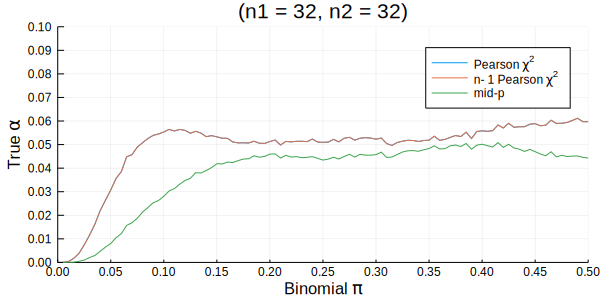

In [72]:
using Random, Distributions, Plots

function calc_chisq(y1, y2, n1, n2) 
    p1 = y1 / n1
    p2 = y2 / n2
    n = n1 + n2
    y = y1 + y2
    p = y / n
    if p == 0 || p == 1
        chisq = 0 # ゼロのときはカイ2乗値をゼロ
    else
        chisq = (p1 - p2)^2  / ((1/n1 + 1/n2) * p * (1-p))
    end
    return chisq
end

# 2×2表に対して，表の生起確率に基づくmid-P版Fisher「正確」検定の
# の有意（true), 非有意(false)を戻す
function calc_flag_midp_2by2(y1, y2, n1, n2, sig)
    y = y1 + y2
    dist_hyp = Hypergeometric(n1, n2, y)
    prob_now = pdf(dist_hyp, y1)
    imax = min(n1, y)
    midp = 0    
    # 小さいほうからのループ
    for i in 0:imax
        prob_temp = pdf(dist_hyp, i)
        if isapprox(prob_temp, prob_now)　# isapprox関数は，approx equalを判定
            midp += 0.5 * prob_now        # mid-p
            if midp > sig                 # 有意水準以上になっていれば，その時点で終了
                return false
            end
            global last_i = i
            break
        elseif prob_temp < prob_now      # 小さければ，そのまま足す
            midp += prob_temp
            if midp > sig                 #有意水準以上になっていれば，その時点で終了
                return false
            end
        end
    end
    # 大きいほうからのループ
    for j in imax:(-1):(last_i + 1)
        prob_temp = pdf(dist_hyp, j)
        if isapprox(prob_temp, prob_now)　# isapprox関数は，approx equalを判定
            midp += 0.5 * prob_now        # mid-p
            if midp > sig                 #有意水準以上になっていれば，その時点で終了
                return false
            end
            break
        elseif prob_temp < prob_now      # 小さければ，そのまま足す
            midp += prob_temp
            if midp > sig                 #有意水準以上になっていれば，その時点で終了
                return false
            end
        end
    end

    return midp <= sig       # #最終的にユニークな値をカウントしたいので，ここでは丸めています
end



Random.seed!(12345) # 乱数シードの設定

sig = 0.05
q = quantile.(Chisq(1), 1 - sig)

nsim = 100000 # 乱数シミュレーションの回数
n = [4, 8, 12, 16, 20, 24, 28, 32]     # 群の標本サイズ
length_n = length(n) 

# 自由度1の95%分位点（5%の棄却域下限）
sig = 0.05
q = quantile.(Chisq(1), 1 - sig)

p = plot()
a_pi = [k/200 for k in 1:100]
for i in 1:length_n
    for j in i:length_n
        a_sig_pearson = Float64[]
        a_sig_n_1_pearson = Float64[]
        a_sig_midp = Float64[]
        for k in 1:100
            pi = a_pi[k]
            dist_bin1 = Binomial(n[i], pi)
            dist_bin2 = Binomial(n[j], pi)
            y1 = rand(dist_bin1, nsim)
            y2 = rand(dist_bin2, nsim)
            chisq = map((y1, y2) -> calc_chisq(y1, y2, n[i], n[j]), y1, y2)
            na = n[i] + n[j]
            n_1_chisq =  chisq
            flag_pearson = map(chisq ->  chisq >= q, chisq)
            flag_n_1_pearson = map(chisq ->  (na - 1) / na * chisq >= q, chisq)
            flag_midp = map((y1, y2) -> calc_flag_midp_2by2(y1, y2, n[i], n[j], sig), y1, y2)
            push!(a_sig_pearson, sum(flag_pearson)/nsim)
            push!(a_sig_n_1_pearson, sum(flag_n_1_pearson)/nsim)
            push!(a_sig_midp, sum(flag_midp)/nsim)
        end
        p = plot(a_pi,a_sig_pearson, title="(n1 = $(n[i]), n2 = $(n[j]))", label="Pearson \\chi^2",
                xaxis = ("Binomial \\pi", (0.00, 0.50), 0:0.05:0.5), 
                yaxis = ("True \\alpha", (0.00, 0.10), 0:0.01:0.10),
                size = (600, 300))
        plot!(p, a_pi, a_sig_n_1_pearson, label="n-1 Pearson \\chi^2")
        plot!(p, a_pi, a_sig_midp, label="mid-p")
        
        display(p)
    end     
end